In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요한 모듈 import하기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
# 파일로부터 영상을 읽어서 data에 저장하기
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/drive/MyDrive/ML/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/ML/chest_xray/test')
#val = get_training_data('./chest_xray/val')

<ipython-input-7-baadddfbe286>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
print(train[500][1])

0


In [ ]:
train.shape

(5216, 2)

In [ ]:
test.shape

(624, 2)

In [ ]:
for feature, label in train:
  print(feature)
  print(label)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[[ 45  39  36 ... 127 141 132]
 [ 57  52  43 ... 128 123 118]
 [ 56  63  57 ... 117 113 109]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
1
[[117 113  91 ... 125 135 134]
 [110 110  84 ... 118 114 114]
 [109 104  83 ... 110 110 114]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
1
[[26 31 35 ... 53 56 52]
 [25 26 29 ... 53 55 47]
 [24 28 36 ... 55 55 49]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
1
[[35 41 53 ...  0  0  0]
 [33 41 51 ...  0  0  0]
 [33 42 50 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
1
[[ 6  5  6 ...  9 10 10]
 [ 5  5  6 ...  7  7  8]
 [ 4  4  5 ...  7  9  8]
 ...
 [ 5  4  3 ...  8  8  7]
 [ 3  4  3 ...  7  8  8]
 [ 5  4  5 ...  8  8  8]]
1
[[128  96  96 ...  68  75  78]
 [196 133  89 ...  79  87  92]
 [147 202 159 ...  90  94  97]
 ...
 [  

Text(0.5, 1.0, 'NORMAL')

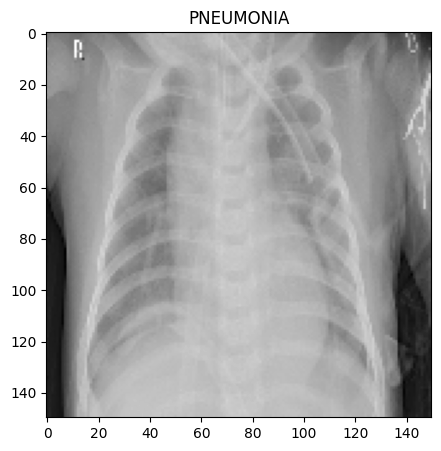

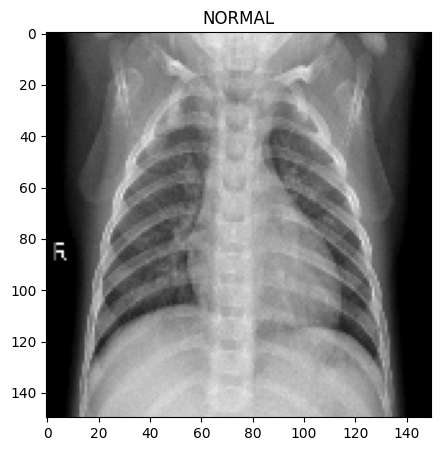

In [ ]:
#영상으로 보이기
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
#for feature, label in val:
#    x_val.append(feature)
#    y_val.append(label)

In [ ]:
# 데이터를 Normalize 0~255  --->   0~1
x_train = np.array(x_train) / 255
#x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# 딥러닝을 위해 data를 resize
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

#x_val = x_val.reshape(-1, img_size, img_size, 1)
#y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# data augmentation하기 (overfitting을 막고, 데이터셋내의 데이터 불균형도 어느 정도 해소)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
# 모델을 만들기
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
#learning_rate를 줄이는 방법. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = 15 ,callbacks = [learning_rate_reduction])
#배치사이즈를 64로 epochs를 10으로 바꿔줌.

Epoch 1/15
82/82 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.8359

82/82 [==============================] - 277s 3s/step - loss: 0.7140 - accuracy: 0.8359 - lr: 0.0010
Epoch 2/15
82/82 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8905

82/82 [==============================] - 260s 3s/step - loss: 0.2695 - accuracy: 0.8905 - lr: 0.0010
Epoch 3/15
82/82 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9168

82/82 [==============================] - 254s 3s/step - loss: 0.2093 - accuracy: 0.9168 - lr: 0.0010
Epoch 4/15
82/82 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9260

82/82 [==============================] - 260s 3s/step - loss: 0.1934 - accuracy: 0.9260 - lr: 0.0010
Epoch 5/15
82/82 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9408

82/82 [==============================] - 257s 3s/step - loss: 0.1599 - accuracy: 0.9408 - lr: 0.0010
Epoch 6/15
82/82 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9381

82/82 [==============================] - 259s 3s/step - loss: 0.1654 - accuracy: 0.9381 - lr: 0.0010
Epoch 7/15
82/82 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9452

82/82 [==============================] - 257s 3s/step - loss: 0.1583 - accuracy: 0.9452 - lr: 0.0010
Epoch 8/15
82/82 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9479

82/82 [==============================] - 268s 3s/step - loss: 0.1363 - accuracy: 0.9479 - lr: 0.0010
Epoch 9/15
82/82 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9546

82/82 [==============================] - 260s 3s/step - loss: 0.1306 - accuracy: 0.9546 - lr: 0.0010
Epoch 10/15
82/82 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9555

82/82 [==============================] - 269s 3s/step - loss: 0.1325 - accuracy: 0.9555 - lr: 0.0010
Epoch 11/15
82/82 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9540

82/82 [==============================] - 263s 3s/step - loss: 0.1309 - accuracy: 0.9540 - lr: 0.0010
Epoch 12/15
82/82 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9536

82/82 [==============================] - 261s 3s/step - loss: 0.1234 - accuracy: 0.9536 - lr: 0.0010
Epoch 13/15
82/82 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.9582

82/82 [==============================] - 258s 3s/step - loss: 0.1206 - accuracy: 0.9582 - lr: 0.0010
Epoch 14/15
82/82 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9567

82/82 [==============================] - 259s 3s/step - loss: 0.1191 - accuracy: 0.9567 - lr: 0.0010
Epoch 15/15
82/82 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9653

82/82 [==============================] - 260s 3s/step - loss: 0.1061 - accuracy: 0.9653 - lr: 0.0010


In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 8s 395ms/step - loss: 1.0474 - accuracy: 0.7147
Loss of the model is -  1.0473583936691284
20/20 [==============================] - 7s 342ms/step - loss: 1.0474 - accuracy: 0.7147
Accuracy of the model is -  71.47436141967773 %


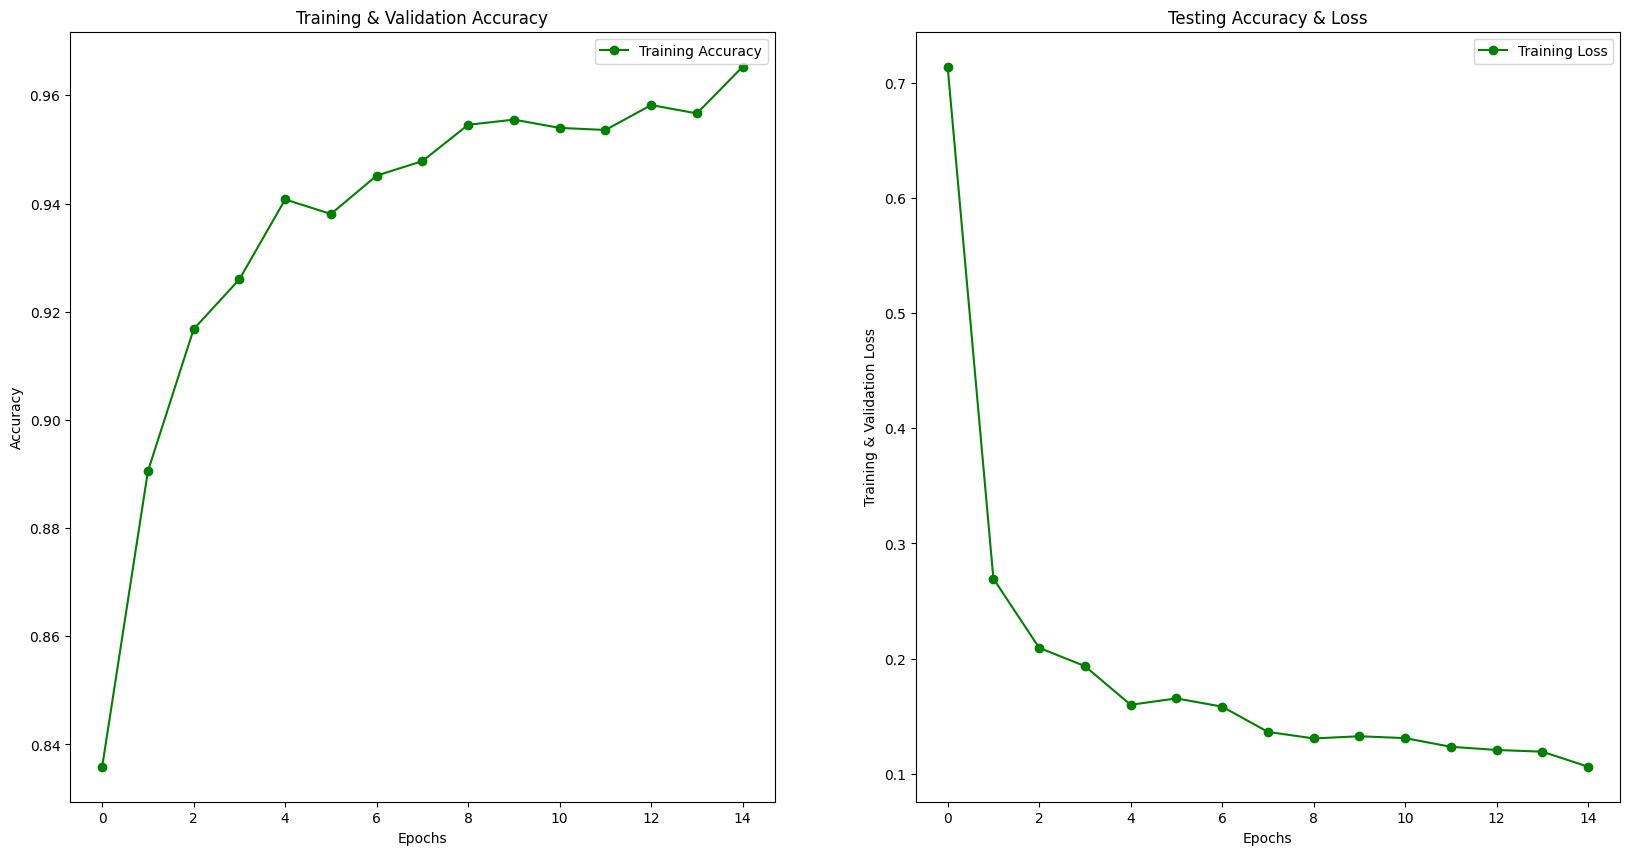

In [ ]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
#val_acc = history.history['val_accuracy']
#val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
#ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
#ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 7s 335ms/step


array([2.0937073e-17, 4.3092123e-21, 0.0000000e+00, 1.9514964e-26,
       4.1302690e-15, 4.2223766e-32, 2.0179427e-01, 2.4626033e-02,
       2.3446871e-02, 2.9262004e-04, 9.6854752e-20, 6.9800075e-07,
       1.4413529e-10, 2.4749194e-23, 5.4333696e-35], dtype=float32)

In [ ]:
preds_1d = predictions.flatten() # 차원 펴주기
preds_1d

array([2.09370729e-17, 4.30921235e-21, 0.00000000e+00, 1.95149643e-26,
       4.13026902e-15, 4.22237659e-32, 2.01794267e-01, 2.46260334e-02,
       2.34468710e-02, 2.92620040e-04, 9.68547524e-20, 6.98000747e-07,
       1.44135287e-10, 2.47491935e-23, 5.43336964e-35, 5.23164267e-09,
       6.40429870e-27, 1.59457413e-04, 1.76889259e-07, 1.90373731e-13,
       3.41738851e-05, 1.50056835e-03, 2.17425775e-08, 4.05879142e-25,
       3.10984805e-17, 4.93419388e-19, 0.00000000e+00, 1.60383537e-01,
       4.78858411e-01, 3.47128775e-23, 4.97194126e-28, 2.01073978e-02,
       3.31788260e-06, 2.28337955e-38, 0.00000000e+00, 1.76639058e-13,
       1.49136186e-02, 2.12555173e-09, 8.92699699e-21, 1.85942817e-02,
       2.17263934e-17, 1.08420459e-34, 1.17130077e-03, 0.00000000e+00,
       7.66798521e-34, 5.51955764e-15, 6.20796413e-07, 3.17968647e-14,
       2.01539885e-15, 4.24533896e-03, 6.25217854e-06, 1.96720212e-16,
       9.79265757e-03, 1.35606073e-03, 2.84163358e-32, 7.78332576e-02,
      

In [ ]:
pred_class = np.where(preds_1d > 0.5, 1 , 0) #0.5보다크면 1, 작으면 0
pred_class
#NORMAL과 PNEUMONIA데이터를 500로 줄이기 전에는 1과 0으로 잘 분류하였으나 500개로 줄인 후 모두 0으로 분류하는 것으로 보아 원인은 데이터 부족으로 보임.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print(classification_report(y_test, pred_class, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.69      1.00      0.81       390
   Normal (Class 1)       0.98      0.24      0.39       234

           accuracy                           0.71       624
          macro avg       0.84      0.62      0.60       624
       weighted avg       0.80      0.71      0.66       624



In [ ]:
cm = confusion_matrix(y_test,pred_class)
cm

array([[389,   1],
       [177,  57]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

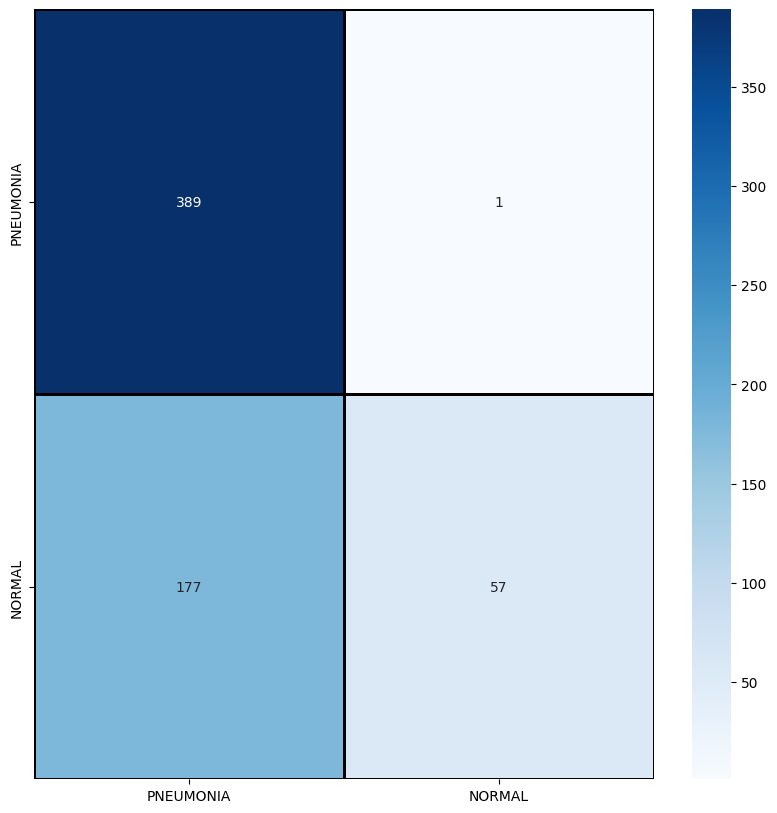

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)